In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import functools

import numpy as np
import scipy as sp
import ultraplot as uplt
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrng

from folx import forward_laplacian

In [40]:
from qtmc import qtmc


def _neg_log_like_gauss1d(x, sigma, mu=0.0):
    return 0.5 * jnp.sum((x-mu)**2) / sigma**2 + jnp.log(sigma) + 0.5 * jnp.log(2.0 * jnp.pi)


def _neg_log_like(x):
    MU = 0.5
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2

    # return _neg_log_like_gauss1d(x, 1)
    # return -1.0 * jsp.special.logsumexp(
    #     jnp.array([
    #         -_neg_log_like_gauss1d(x, 0.5, mu=-MU) + jnp.log(0.5),
    #         -_neg_log_like_gauss1d(x, 1, mu=MU) + jnp.log(0.5),
    #     ])
    # )
    return jnp.sum(-5.0*x*x + x*x*x*x) + jnp.log(2.0 * 301.60)


def _log_like(x):
    return -1.0 * _neg_log_like(x)

sampling: 100%|███████████████████████| 40001/40001 [00:00<00:00, 100254.41it/s]


acceptance rate: 14.49%
effective sample size: 3.7121847584451424 0.009280461896112856


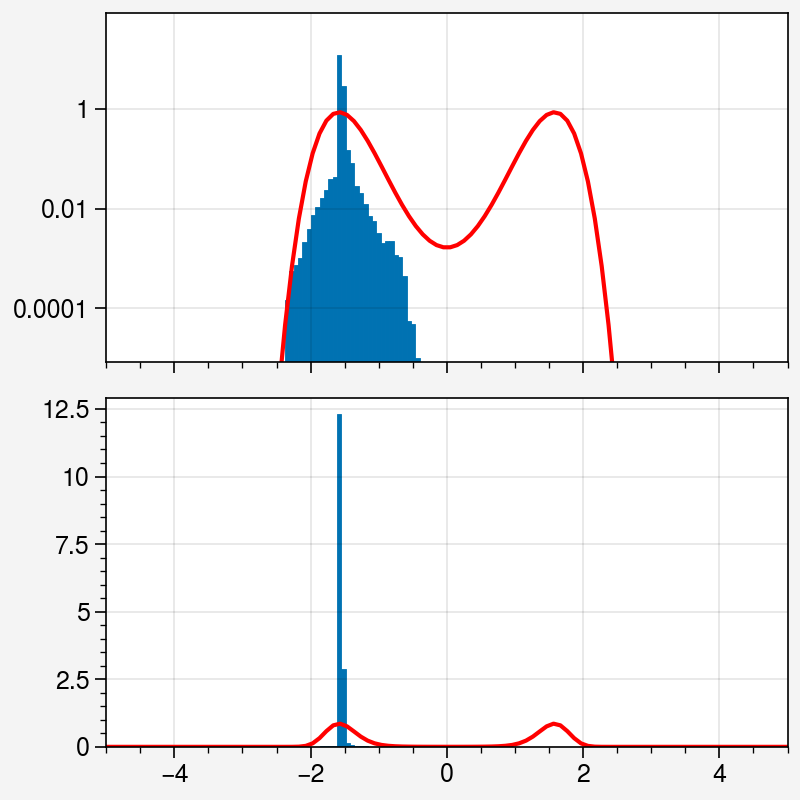

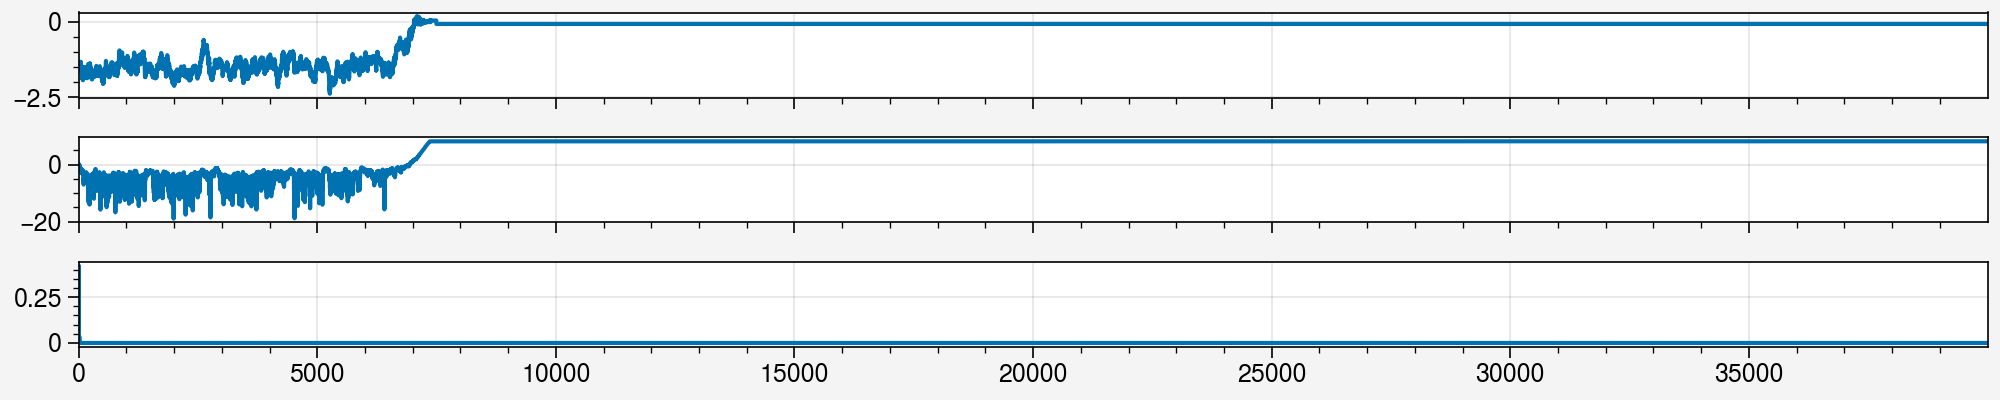

In [83]:
import random

n_dims = 1
n_samples = 40000
rng_key = jrng.key(seed=random.SystemRandom().randint(1, 1000000000))

with jax.debug_nans(False):
    chain, logwgts, acc, loglike, r = qtmc(
        rng_key,
        _log_like,
        n_dims,
        n_samples,
        m=1,
        hbar=1e-4,
        params_init=jnp.array([-1.5]),
        leapfrog_step_size=0.01,
        n_leapfrog_steps=5,
        verbose=True,
        debug=True if n_samples < 10 else False,
    )

n_keep = 0 # n_samples // 2
w = jnp.exp(logwgts.ravel()[-n_keep:] - jsp.special.logsumexp(logwgts.ravel()[-n_keep:]))
ess = np.sum(w)**2 / np.sum(w**2)
print("effective sample size:", ess, ess / (n_samples - n_keep) * 100)

x = jnp.linspace(-5, 5, 100)
ll = jax.vmap(_log_like)(x)
fig, axs = uplt.subplots(nrows=2, ncols=1, figsize=(4, 4))
axs[0, 0].hist(chain.ravel()[n_keep:], weights=w, bins=40, density=True, log=True);
nrm = jnp.trapezoid(jnp.exp(ll), x)
axs[0, 0].plot(x, jnp.exp(ll) / nrm, color="r");
mval = jnp.max(jnp.exp(ll) / nrm)
axs[0, 0].format(ylim=(mval * 1e-5, mval * 1e2))

axs[1, 0].hist(chain.ravel()[n_keep:], weights=w, bins=40, density=True, log=False);
nrm = jnp.trapezoid(jnp.exp(ll), x)
axs[1, 0].plot(x, jnp.exp(ll) / nrm, color="r");

# axs.format(ylim=(0.0000001, 10.0))

fig, axs = uplt.subplots(nrows=3, ncols=1, figsize=(10, 2))

ax = axs[0, 0]
ax.plot(chain.ravel()[n_keep:])
ax = axs[1, 0]
ax.plot(jnp.log(r.ravel()[n_keep:]));
ax = axs[2, 0]
ax.plot((w.ravel()));